In [60]:

function velocityRS(x,y,s,F,delta, δs)
    
    u = zeros(2, length(s))
    int_u = zeros(size(u))
    r1 = zeros(size(x))
    r2 = zeros(size(y))
    F_dot_r = zeros(size(x))
    R2 = zeros(size(x))
    for i = 1:length(s)

        r1 .= x .- x[i]
        r2 .= y .- y[i]
        R2 .= r1 .^ 2 + r2 .^ 2
        F_dot_r .= (F[1, i] .* r1) .+ (F[2, i] .* r2)

        int_u[1, :] = (1 / (8 * pi)) * ((F[1, i] .* (R2 .+ 2 * delta^2)) ./ ((R2 .+ delta^2) .^ 1.5) .+ (F_dot_r .* (r1)) ./ ((R2 .+ delta^2) .^ 1.5))

        int_u[2, :] = (1 / (8 * pi)) * ((F[2, i] .* (R2 .+ 2 * delta^2)) ./ ((R2 .+ delta^2) .^ 1.5) .+ (F_dot_r .* (r2)) ./ ((R2 .+ delta^2) .^ 1.5))

        if i != 1 && i != length(s)
            u[1, :] = u[1, :] .+ (int_u[1, :]) * δs
            u[2, :] = u[2, :] .+ (int_u[2, :]) * δs
        else
            u[1, :] = u[1, :] .+ 0.5 * (int_u[1, :]) * δs
            u[2, :] = u[2, :] .+ 0.5 * (int_u[2, :]) * δs
        end
    end
    return u
end

velocityRS (generic function with 1 method)

In [62]:
#  @time begin
# import Pkg; Pkg.add("DifferentialEquations")
# import Pkg; Pkg.add("Plots")
# using ProfileView
using DifferentialEquations, Plots
# params = (S_T = 64,S_C = 12,L = 7,Amp = 0.55,N = 51, dt = 1e-4)

function RSFILL(S_T, S_C, L, Amp, N, t0, tmax, dt)

# S_T, S_C, L, Amp, N, dt = p
# S_T = 64;
# S_C = 12;
# L = 7;
# Amp = 0.55;
λ = 2.25 * π / L;


# N = 51;
δs = L / (N - 1);
s_range = (0.0, L);

δ = (2 / 3) * δs;
f(u, p, s) = sqrt(1 - Amp ^ 2 * λ ^ 2 * (cos(λ * s)) .^ 2)

x0 = 0;
prob = ODEProblem(f, x0, s_range)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, saveat=δs)

y = Amp * sin.(λ * sol.t);


delta = (2 / 3) * δs;

s = sol.t
# x=zeros(size(s))
# y=zeros(size(s))
x = sol';
y = y';

k(ss, tt) = Amp * λ^2 * sin(λ * ss - 2 * pi * tt) / (sqrt(1 - Amp^2 * λ^2 * (cos(λ * ss - 2 * pi * tt))^2));

F = zeros(2, length(s));
# t = 0;

# dt = 1e-4;
# tmax = 1;
nmax = round((tmax -t0)/ dt);
anim=Animation()
for n = 1:nmax

    for i = 1:length(s)-1
        X_s = [x[i+1] .- x[i], y[i+1] .- y[i]]
        X_s_distance2 = (X_s[1] ^ 2 + X_s[2] ^ 2)
        F_t = -S_T * ((sqrt(X_s_distance2) / δs) - 1) * (X_s / (sqrt(X_s_distance2)))

        # F[1, i] = F[1, i] .- F_t[1]
        # F[1, i+1] = F[1, i+1] .+ F_t[1]
        # F[2, i] = F[2, i] .- F_t[2]
        # F[2, i+1] = F[2, i+1] .+ F_t[2]



        F[1, i] = F[1, i] - F_t[1]
        F[1, i+1] = F[1, i+1] + F_t[1]
        F[2, i] = F[2, i] - F_t[2]
        F[2, i+1] = F[2, i+1] + F_t[2]
    end

    for i = 2:length(s)-1
        κ = k.(s[i], t0)

        D2_x_i = (x[i+1] .- 2 * x[i] .+ x[i-1]) / (δs^2)
        D0_x_i = (x[i+1] .- x[i-1]) / (2 * δs)

        D2_y_i = (y[i+1] .- 2 * y[i] .+ y[i-1]) / (δs^2)
        D0_y_i = (y[i+1] .- y[i-1]) / (2 * δs)


        # F1 = S_C * ((D2_x_i .* D0_y_i .- D0_x_i .* D2_y_i) .- κ) .* (D0_y_i / δs)
        # F2 = -S_C * ((D2_x_i .* D0_y_i .- D0_x_i .* D2_y_i) .- κ) .* (D0_x_i / δs)
        # Q1 = -S_C * 0.5 * ((D2_x_i .* D0_y_i .- D0_x_i .* D2_y_i) .- κ) .* (D2_y_i)
        # Q2 = S_C * 0.5 * ((D2_x_i .* D0_y_i .- D0_x_i .* D2_y_i) .- κ) .* (D2_x_i)



        F1 = S_C * ((D2_x_i  * D0_y_i  - D0_x_i  * D2_y_i) - κ) * (D0_y_i / δs)
        F2 = -S_C * ((D2_x_i * D0_y_i - D0_x_i * D2_y_i) - κ) * (D0_x_i / δs)
        Q1 = -S_C * 0.5 * ((D2_x_i * D0_y_i - D0_x_i * D2_y_i) - κ) * (D2_y_i)
        Q2 = S_C * 0.5 * ((D2_x_i * D0_y_i - D0_x_i * D2_y_i) - κ) * (D2_x_i)


        # F[1, i+1] = F[1, i+1] .- F1 .- Q1
        # F[1, i] = F[1, i] .+ 2 * F1
        # F[1, i-1] = F[1, i-1] .- F1 .+ Q1

        # F[2, i+1] = F[2, i+1] .- F2 .- Q2
        # F[2, i] = F[2, i] .+ 2 * F2
        # F[2, i-1] = F[2, i-1] .- F2 .+ Q2



        F[1, i+1] = F[1, i+1] - F1 - Q1
        F[1, i] = F[1, i] + 2 * F1
        F[1, i-1] = F[1, i-1] - F1 + Q1

        F[2, i+1] = F[2, i+1] - F2 - Q2
        F[2, i] = F[2, i] .+ 2 * F2
        F[2, i-1] = F[2, i-1] - F2 + Q2
    end
   

    u=velocityRS(x,y,s,F,delta,δs);

    for i = 1:length(s)

        # x[i] = x[i] .+ dt * u[1, i]
        # y[i] = y[i] .+ dt * u[2, i]

        x[i] = x[i] + dt * u[1, i]
        y[i] = y[i] + dt * u[2, i]

    end

    t0 = t0 + dt

    if mod(n, 100) == 0

        plot(x', y', xlims=(0,L),ylims=(-1,1.5),aspect_ratio=:equal, legend=:false,marker=:circle,lw=3)
#     quiver!(x',y',quiver=(F[1,:]',F[2,:]'))

        annotate!(3, 1.25, "Time= $(rpad(round(t0; digits=2),4,"0")) s")
        frame(anim)

        #sleep(dt)

    end

end

vid=gif(anim, "anim_RS001.gif", fps = 10)
return vid
end


RSFILL (generic function with 3 methods)

[ Info: Saved animation to c:\Users\mosle\OneDrive - Tulane University\anim_RS001.gif


Plots.AnimatedGif("c:\\Users\\mosle\\OneDrive - Tulane University\\anim_RS001.gif")
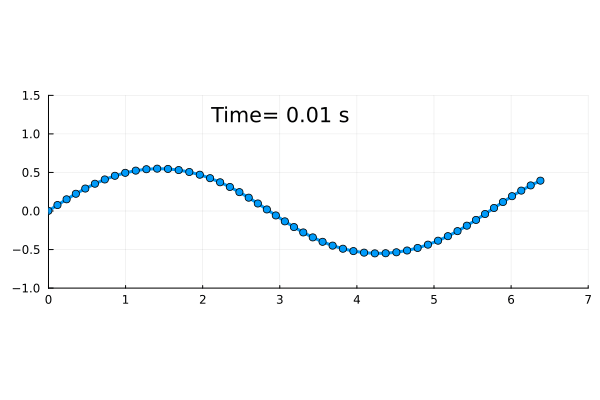

In [59]:
RSFILL(64,  12, 7,  0.55, 51,0,1, 1e-4)

In [ ]:
@time begin 
    dt =1e-4; 
    print(dt); 
    dx=0.2;
x=0;
f(x)=sin(x)
for i=1:9
    x=x+dx;
    print(x)
end

end


0.00010.20.40.60000000000000010.81.01.21.41.59999999999999991.7999999999999998  0.034760 seconds (152 allocations: 8.734 KiB)


In [ ]:
a=[1 2 5 10]
for i=1: length(a)
    
    if i!=1  &&  i!=4
        a[i]=a[i] .+ 5
    else
        a[i]=a[i] .+ 8
    end
    
end
print(a)


[9 7 10 18]

## dws

In [22]:
using Plots
# plotlyjs()
τ= [0 π/2 π 3*π/2]  
Λs=0.3
c=0.2
lbs= ["0" "π/2" "π" "3*π/2"] 
p = plot()
for m=1:length(τ)
# f1=(1+Λs)*sin.(τ[i]-η/(sqrt(2)))-(c+Λs)*cos.(τ[i]-η/(sqrt(2)));
# f2=(1+Λs)^2+(c+Λs)^2;
f(η;Λs,c,τ)=(((1+Λs)*sin.(τ[m]-η/(sqrt(2)))-(c+Λs)*cos.(τ[m]-η/(sqrt(2)))) ./ ((1+Λs)^2+(c+Λs)^2))*exp(-η/sqrt(2));

    
plot!(range(0,6,100), η->f(η;Λs,c,τ); xlabel="η", ylabel="u",seriestype=:line,lw=3,label=lbs[m], marker = :circle , leg_title = "τ",fmt="png") 
# xflip!()
# yflip!()
#     sleep(0.001)
end
p

WebIO._IJuliaInit()

: 

: 

: 

In [ ]:
using Plots
# plotlyjs()
τ= [0 π/2 π 3*π/2]  
Λs=0.3
c=0.2
lbs= ["0" "π/2" "π" "3*π/2"] 
p = plot()
for m=1:length(τ)
# f1=(1+Λs)*sin.(τ[i]-η/(sqrt(2)))-(c+Λs)*cos.(τ[i]-η/(sqrt(2)));
# f2=(1+Λs)^2+(c+Λs)^2;
f(η;Λs,c,τ)=(((1+Λs)*sin.(τ[m]-η/(sqrt(2)))-(c+Λs)*cos.(τ[m]-η/(sqrt(2)))) ./ ((1+Λs)^2+(c+Λs)^2))*exp(-η/sqrt(2));

    
plot!(range(0,6,100), η->f(η;Λs,c,τ); xlabel="η", ylabel="u",seriestype=:line,lw=3,label=lbs[m], marker = :circle , leg_title = "τ",fmt="png") 
# xflip!()
# yflip!()
#     sleep(0.001)
end
p

ERROR: LoadError: 

ArgumentError: Package LogExpFunctions does not have ChainRulesCore in its dependencies:
- You may have a partially installed environment. Try `Pkg.instantiate()`
  to ensure all packages in the environment are installed.
- Or, if you have LogExpFunctions checked out for development and have
  added ChainRulesCore as a dependency but haven't updated your primary
  environment's manifest file, try `Pkg.resolve()`.
- Otherwise you may need to report an issue with LogExpFunctions
Stacktrace:
 [1] macro expansion
   @ .\loading.jl:1167 [inlined]
 [2] macro expansion
   @ .\lock.jl:223 [inlined]
 [3] require(into::Module, mod::Symbol)
   @ 

Base .\loading.jl:1144
 [4] include(mod::Module, _path::String)
   @ Base .\Base.jl:419
 [5] include(x::String)
   @ LogExpFunctions C:\Users\mosle\.julia\packages\LogExpFunctions\jq98q\src\LogExpFunctions.jl:1
 [6] top-level scope
   @ C:\Users\mosle\.julia\packages\LogExpFunctions\jq98q\src\LogExpFunctions.jl:17
 [7] include
   @ .\Base.jl:419 [inlined]
 [8] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt64}}, source::String)
   @ Base .\loading.jl:1554
 [9] top-level scope
   @ stdin:1
in expression starting at C:\Users\mosle\.julia\packages\LogExpFunctions\jq98q\ext\LogExpFunctionsChainRulesCoreExt.jl:1
in expression starting at C:\Users\mosle\.julia\packages\LogExpFunctions\jq98q\src\LogExpFunctions.jl:1
in expression starting at stdin:1


ERROR: LoadError: 

Failed to precompile LogExpFunctions [2ab3a3ac-af41-5b50-aa03-7779005ae688] to C:\Users\mosle\.julia\compiled\v1.8\LogExpFunctions\jl_92B2.tmp.
Stacktrace:
  [1] error(s::

String)
    @ Base .\error.jl:35
  [2] compilecache(pkg::Base.PkgId, path::String, internal_stderr::IO, internal_stdout::IO, keep_loaded_modules::Bool)
    @ Base .\loading.jl:1707
  [3] compilecache
    @ .\loading.jl:1651 [inlined]
  [4] _require(pkg::Base.PkgId)
    @ Base .\loading.jl:1337
  [5] _require_prelocked(uuidkey::Base.PkgId)
    @ Base .\loading.jl:1200
  [6] macro expansion
    @ .\loading.jl:1180 [inlined]
  [7] macro expansion
    @ .\lock.jl:223 [inlined]
  [8] require(into::Module, mod::Symbol)
    @ Base .\loading.jl:1144
  [9] include
    @ .\Base.jl:419 [inlined]
 [10] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt64}}, source::String)
    @ Base .\loading.jl:1554
 [11] top-level scope
    @ stdin:1
in expression starting at C:\Users\mosle\.julia\packages\SpecialFunctions\gXPNz\src\SpecialFunctions.jl:1
in expression starting

ERROR: LoadError: 

Failed to precompile SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] to C:\Users\mosle\.julia\compiled\v1.8\SpecialFunctions\jl_917A.tmp.


Stacktrace:
  [1] error(s::String)
    @ Base .\error.jl:35
  [2] compilecache(pkg::Base.PkgId, path::String, internal_stderr::IO, internal_stdout::IO, keep_loaded_modules::Bool)
    @ Base .\loading.jl:1707
  [3] compilecache
    @ .\loading.jl:1651 [inlined]
  [4] _require(pkg::Base.PkgId)
    @ Base .\loading.jl:1337
  [5] _require_prelocked(uuidkey::Base.PkgId)
    @ Base .\loading.jl:1200
  [6] macro expansion
    @ .\loading.jl:1180 [inlined]
  [7] macro expansion
    @ .\lock.jl:223 [inlined]
  [8] require(into::Module, mod::Symbol)
    @ Base .\loading.jl:1144
  [9] include
    @ .\Base.jl:419 [inlined]
 [10] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt64}}, source::String)
    @ Base .\loading.jl:1554
 [11] top-level scope
    @ stdin:1
in expression starting at C:\Users\mosle\.julia\packages\ColorVectorSpace\QI5vM\src\ColorVectorSpace

ERROR: LoadError: 

Failed to precompile ColorVectorSpace [c3611d14-8923-5661-9e6a-0046d554d3a4] to C:\Users\mosle\.julia\compiled\v1.8\ColorVectorSpace\jl_8E3E.tmp.
Stacktrace:
  [1] error(s::String)
    @ Base .\error.jl:35
  [2] compilecache(pkg::Base.PkgId, path::String, internal_stderr::IO, internal_stdout::IO, keep_loaded_modules::Bool)
    @ Base .\loading.jl:1707
  [3] compilecache
    @ .\loading.jl:1651 [inlined]
  [4] _require(pkg::Base.PkgId)
    @ Base .\loading.jl:1337
  [5] _require_prelocked(uuidkey::Base.PkgId)
    @ Base .\loading.jl:1200
  [6] macro expansion
    @ .\loading.jl:1180 [inlined]
  [7] macro expansion
    @ .\lock.jl:223 [inlined]
  [8] require(into::Module, mod::Symbol)
    @ Base .\loading.jl:1144
  [9] include
    @ .\Base.jl:419 [inlined]
 [10] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt64}}, source::String)
    @ Base .\loading

ERROR: LoadError: 

Failed to precompile ColorSchemes [35d6a980-a343-548e-a6ea-1d62b119f2f4] to C:\Users\mosle\.julia\compiled\v1.8\ColorSchemes\jl_8A56.tmp.
Stacktrace:
  [1] error(s::String)
    @ Base .\error.jl:35
  [2] compilecache(pkg::Base.PkgId, path::String, internal_stderr::IO, internal_stdout::IO, keep_loaded_modules::Bool)
    @ Base .\loading.jl:1707
  [3] compilecache
    @ .\loading.jl:1651 [inlined]
  [4] _require(pkg::Base.PkgId)
    @ Base .\loading.jl:1337
  [5] _require_prelocked(uuidkey::Base.PkgId)
    @ Base .\loading.jl:1200
  [6] macro expansion
    @ .\loading.jl:1180 [inlined]
  [7] macro expansion
    @ .\lock.jl:223 [inlined]
  [8] require(into::Module, mod::Symbol)
    @ Base .\loading.jl:1144
  [9] include
    @ .\Base.jl:419 [inlined]
 [10] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt64}}, source::String)
    @ Base .\loading.jl:1554

ERROR: LoadError: 

Failed to precompile PlotUtils [995b91a9-d308-5afd-9ec6-746e21dbc043] to C:\Users\mosle\.julia\compiled\v1.8\PlotUtils\jl_86CB.tmp.
Stacktrace:
  [1] error(s::String)
    @ Base .\error.jl:35
  [2] compilecache(pkg::Base.PkgId, path::String, internal_stderr::IO, internal_stdout::IO, keep_loaded_modules::Bool)
    @ Base .\loading.jl:1707
  [3] compilecache
    @ .\loading.jl:1651 [inlined]
  [4] _require(pkg::Base.PkgId)
    @ Base .\loading.jl:1337
  [5] _require_prelocked(uuidkey::Base.PkgId)
    @ Base .\loading.jl:1200
  [6] macro expansion
    @ .\loading.jl:1180 [inlined]
  [7] macro expansion
    @ .\lock.jl:223 [inlined]
  [8] require(into::Module, mod::Symbol)
    @ Base .\loading.jl:1144
  [9] include
    @ .\Base.jl:419 [inlined]
 [10] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt64}}, source::String)
    @ Base .\loading.jl:1554
 [11]

ERROR: LoadError: 

Failed to precompile PlotThemes [ccf2f8ad-2431-5c83-bf29-c5338b663b6a] to C:\Users\mosle\.julia\compiled\v1.8\PlotThemes\jl_85B2.tmp.
Stacktrace:
  [1] error(s::String)
    @ Base .\error.jl:35
  [2] compilecache(pkg::Base.PkgId, path::String, internal_stderr::IO, internal_stdout::IO, keep_loaded_modules::Bool)
    @ Base .\loading.jl:1707
  [3] compilecache
    @ .\loading.jl:1651 [inlined]
  [4] _require(pkg::Base.PkgId)
    @ Base .\loading.jl:1337
  [5] _require_prelocked(uuidkey::Base.PkgId)
    @ Base .\loading.jl:1200
  [6] macro expansion
    @ .\loading.jl:1180 [inlined]
  [7] macro expansion
    @ .\lock.jl:223 [inlined]
  [8] require(into::Module, mod::Symbol)
    @ Base .\loading.jl:1144
  [9] include
    @ .\Base.jl:419 [inlined]
 [10] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt64}}, source::String)
    @ Base .\loading.jl:1554
 [1

ErrorException: Failed to precompile Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] to C:\Users\mosle\.julia\compiled\v1.8\Plots\jl_82B5.tmp.

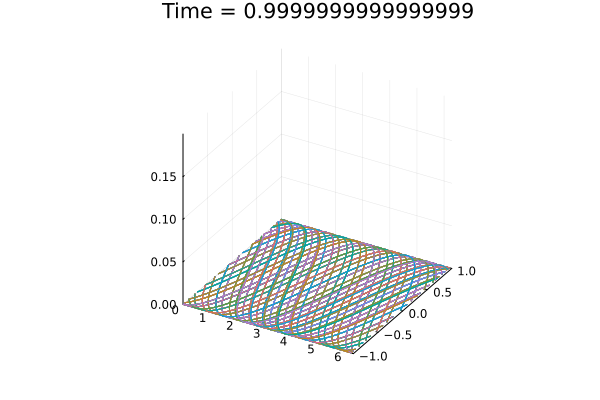

In [6]:
using Plots
x = 0:0.1:2π
t=0
dt=0.1
p=plot3d()
for n in 1:10
    t=t+dt
 for i in 1:30
    y = sin.(x .+ (i/2))
    plot3d!(x, y,zeros(size(x)),legend=false, show=true, xlims=(0,2π), ylims=(-1,1), zlims=(0,0.2))
 
    title!("Time = $t")
       sleep(0.001)
    end
end
p

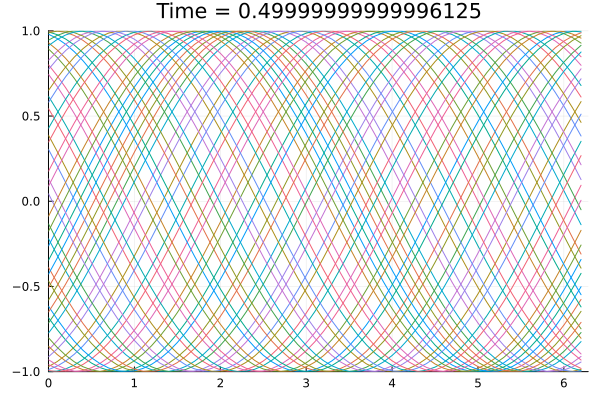

In [5]:
using Plots
t=0
dt =1e-4;
tmax=0.5;
nmax=round(tmax/dt);
p=plot()
for n=1:nmax
    t=t+dt
if mod(n,100)==0
    x = 0:0.1:2π
    y = sin.(x .+ (n/2))
   plot!(x, y, xlims=(0,2π), ylims=(-1,1),legend=false,fmt=png)
   title!("Time = $t")
    sleep(0.1)
end
end
p